# MIRELLA – Notebook 1: Computational analysis to simulate ribosome realloaction

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

imgs_path = os.path.join(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))), 'docs')


class Simulator():
    """Simulator."""
    
    def __init__(self, t_max=5e+2, flag3p=True, params=None, init_cond=None):
        """Constructor."""
        self.flag3p = flag3p
        self.t_max= t_max 
        self.set_model_parameters(params)
        self.set_initial_condition(init_cond)
    
    def set_model_parameters(self, params):
        self.params = dict(params)
    
    def set_aux_params(self):
        self.aux_params = {
            'alpha_t_prime' : self.params['n_t'] * self.params['alpha_t'], 
            'alpha_q_prime' : self.params['n_t'] * self.params['alpha_q'] , 
            'alpha_c_prime' : self.params['n_c'] * self.params['alpha_c'], 
            'eta_plus_prime' : self.params['nTS'] * self.params['eta_plus'] / self.params['n_t'] , 
            'kappa_t' : (self.params['gamma_t'] + self.params['kappa_t_minus']) / self.params['kappa_t_plus'],
            'kappa_c' : (self.params['gamma_c'] + self.params['kappa_c_minus']) / self.params['kappa_c_plus'],
            'beta_t_q' : self.params['lambda_t_q'] * self.params['beta_t']
        }
    
    def set_initial_condition(self, init_condition):
        self.init_cond = dict(init_condition)
    
    def set_x0(self):
        self.x0 = np.array([
            self.init_cond['mt'], 
            self.init_cond['mtq'], 
            self.init_cond['q'], 
            self.init_cond['mc'], 
            self.init_cond['pt'], 
            self.init_cond['pc']
        ])
    
    def simulate_model(self):
        """Simulate the nonlinear state-space model."""
        self.set_aux_params()
        self.set_x0()
        
        tspan = (0, self.t_max)
        soln = solve_ivp(self.ss_model, tspan, self.x0, method='Radau', rtol=1e-6, atol=1e-9)
        
        self.t, self.x = soln.t, soln.y
        self.mt, self.mtq, self.q, self.mc, self.pt, self.pc = self.x
        self.mt_tot = self.mt + self.mtq * self.flag3p
        self.r = self.aux_func_r(
            self.mt_tot / self.aux_params['kappa_t'], 
            self.mc / self.aux_params['kappa_c']
        )
        self.ribo_dens_t, self.ribo_dens_c = self.aux_func_ribo_dens()
    
    def ss_model(self, t, x): 
        mt, mtq, q, mc, pt, pc = x
        mt_tot = mt + mtq * self.flag3p
        
        rho_t_tot = mt_tot / self.aux_params['kappa_t']
        rho_c = mc / self.aux_params['kappa_c']
        r = self.aux_func_r(rho_t_tot, rho_c)
        
        dmt = (
            self.aux_params['alpha_t_prime'] + 
            self.params['eta_minus'] * mtq - 
            (self.params['beta_t'] + self.aux_params['eta_plus_prime'] * q) * mt
            )
        dmtq = (
            self.aux_params['eta_plus_prime'] * mt * q - 
            (self.aux_params['beta_t_q'] + self.params['eta_minus']) * mtq
            )
        dq = (
            self.aux_params['alpha_q_prime'] + 
            (self.aux_params['beta_t_q'] + 
            self.params['eta_minus']) * mtq - 
            (self.params['beta_q'] + self.aux_params['eta_plus_prime'] * mt) * q
            )
        dmc = self.aux_params['alpha_c_prime'] - self.params['beta_c'] * mc
        dpt = self.params['gamma_t'] * rho_t_tot * r - self.params['delta_t'] * pt
        dpc = self.params['gamma_t'] * rho_c * r - self.params['delta_c'] * pc
        return np.array([dmt, dmtq, dq, dmc, dpt, dpc])
    
    def aux_func_r(self, rho_t_tot, rho_c):
        return self.params['r0'] / (1 + rho_t_tot + rho_c)
    
    def aux_func_ribo_dens(self):
        ribo_dens_t = self.params['n_t'] / (self.aux_params['kappa_t'] / self.r + 1)
        ribo_dens_c = self.params['n_c'] / (self.aux_params['kappa_c'] / self.r + 1)
        return ribo_dens_t, ribo_dens_c

Set model parameters for model simulations.

In [2]:
parameters = {
    'alpha_t' : 2., # Effective miTarget mRNA production rate (nM /h) 
    'nTS' : 1., # Number of target sites in either 3' UTR or 5' UTR
    'eta_minus' : 0., # miTarget mRNA/miRNA unbinding rate (/hrs) 
    'beta_t' : np.log(2.)/3., # miTarget mRNA degradation rate (/h)
    'lambda_t_q' : 5., # Conversion factor from miTarget mRNA degradation rate to miTarget+miRNA mRNA degradation rate (adm) 
    'gamma_t' : 53., # miTarget elongation rate (/h) 
    'n_t' : 33., # Max number of ribosomes per miTarget transcript (adm)
    'kappa_t_minus' : 0., # Dissociation constant between miTarget mRNA and free ribosomes (/h) 
    'delta_t' : np.log(2.)/26., # miTarget protein degradation rate (/h) 
    'alpha_q' : 0.05, # Effective miRNA production rate (nM /h) 
    'beta_q' : np.log(2.)/10., # miRNA degradation rate (/h) 
    'alpha_c' : 2., # Effective Capacity monitor mRNA production rate (nM /h) 
    'beta_c' : np.log(2)/3., # Capacity monitor mRNA degradation rate (/h) 
    'gamma_c' : 53., # Capacity monitor elongation rate (/h) 
    'n_c' : 33., # Max number of ribosomes per monitor transcript (adm)
    'kappa_c_minus' : 0., # Dissociation constant between capacity monitor mRNA and free ribosomes (/h) 
    'delta_c' : np.log(2.)/26., # Capacity monitor protein degradation rate (/h) 
    'r0' : 1000. # Total ribosome concentration (nM)
} # Model parameters

Simulate the ODE model to study how miRNA target and capacity monitor vary according to miRNA regulation.

In [3]:
def run_sims(scenarios, params, kappas_plus, etas):
    # Initial condition
    init_cond = {
        'mt' : 0.,
        'mtq' : 0.,
        'q' : 0.,
        'mc' : 0.,
        'pt' : 0.,
        'pc' : 0.
    }
    # Instantiate an object from the class Simulator.
    MiRoBu = Simulator(t_max=1e+4, params=params, init_cond=init_cond) 
    names = list()
    ss_values = list()
    df = list()
    column_names = [
        'eta_plus', 
        'kappa_t_plus', 
        'kappa_c_plus', 
        'mt', 
        'mtq', 
        'mt_tot', 
        'q', 
        'mc', 
        'pt', 
        'pc', 
        'r', 
        'ribo_dens_t', 
        'ribo_dens_c'
    ]
    def get_ss_values(s):
        """Get the steady-state values from the object s"""
        return np.array([s.mt[-1], 
                         s.mtq[-1], 
                         s.mt_tot[-1], 
                         s.q[-1], 
                         s.mc[-1], 
                         s.pt[-1], 
                         s.pc[-1], 
                         s.r[-1], 
                         s.ribo_dens_t[-1], 
                         s.ribo_dens_c[-1]
                        ])
    
    # Simulate the several experimental scenarios.
    for j in range(len(scenarios)):
        MiRoBu.flag3p, MiRoBu.params['nTS'] = scenarios.iloc[j]
        name = 'miRNA_' + str(MiRoBu.params['nTS']) + 'TS_'
        if MiRoBu.flag3p:
            name += '3pUTR_model'
        else:
            name += '5pUTR_model'
        names.append(name)
        ss_values.append([])
        for i in range(kappas_plus.size):
            MiRoBu.params['kappa_t_plus'] = kappas_plus[i]
            MiRoBu.params['kappa_c_plus'] = kappas_plus[i]
            ss_values[j].append(np.empty([etas.size, len(column_names)]))
            for z in range(etas.size):
                MiRoBu.params['eta_plus'] = etas[z]    
                ss_values[j][i][z, 0] = etas[z]
                ss_values[j][i][z, 1:3] = kappas_plus[i] * np.ones(2)
                MiRoBu.simulate_model()
                ss_values[j][i][z, 3:] = get_ss_values(MiRoBu)
    
    # Simulate case: no TS (i.e. control).
    MiRoBu.params['eta_plus'] = 0
    names.append('no_miRNA_model')
    ss_values.append([])
    for i in range(kappas_plus.size):
        MiRoBu.params['kappa_t_plus'] = kappas_plus[i]
        MiRoBu.params['kappa_c_plus'] = kappas_plus[i]
        ss_values[-1].append(np.empty([etas.size, len(column_names)]))
        for z in range(etas.size):
            ss_values[-1][i][z, 0] = etas[z]
            ss_values[-1][i][z, 1:3] = kappas_plus[i] * np.ones(2)
            MiRoBu.simulate_model()
            ss_values[-1][i][z, 3:] = get_ss_values(MiRoBu)
    for j in range(len(names)):
        df.append([])
        for i in range(kappas_plus.size):
            df[j].append(pd.DataFrame(ss_values[j][i], columns=column_names))
    return df

Define the experimental scenarios and run the simulations.

In [4]:
# Experimental scenarios
scenarios = pd.DataFrame([[True, 1], [False, 1], [True, 3], [False, 3]], columns = ['3pUTR', '#TS'])
etas_plus = np.logspace(-3.0, 2.0, num=100)
kappas_plus = np.array([1.])

# Run the simulations
df = run_sims(scenarios, parameters, kappas_plus, etas_plus)

## Fig. 2c

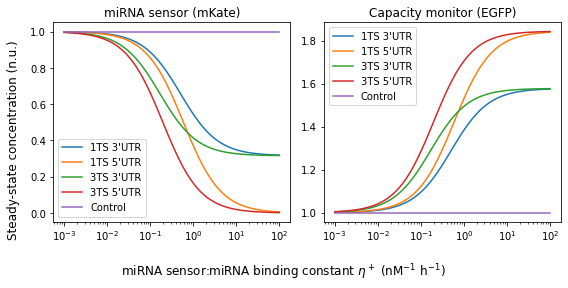

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 4])
time_series_labels = ["1TS 3'UTR", "1TS 5'UTR", "3TS 3'UTR", "3TS 5'UTR", "Control"]
for z in range(len(time_series_labels)):
    ax[0].plot(df[z][0].eta_plus, df[z][0].pt / df[-1][0].pt, label=time_series_labels[z])
    ax[1].plot(df[z][0].eta_plus, df[z][0].pc / df[-1][0].pc, label=time_series_labels[z])
ax[0].set_title('miRNA sensor (mKate)')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].set_title('Capacity monitor (EGFP)')
ax[1].set_xscale('log')
ax[1].legend()
fig.supxlabel(r'miRNA sensor:miRNA binding constant $\eta^+ \ \mathrm{(nM^{-1} \ h^{-1})}$')
fig.supylabel('Steady-state concentration (n.u.)')
fig.tight_layout()

plt.savefig(os.path.join(imgs_path, 'Fig2c.pdf'), format='pdf')

## Fig. 3a: Free ribosomes

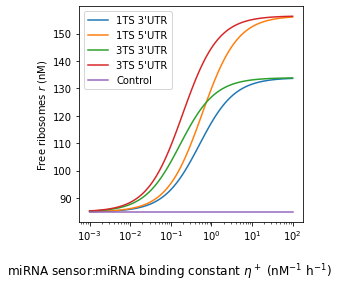

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])

for z in range(len(time_series_labels)):
    ax.plot(df[z][0].eta_plus, df[z][0].r, label=time_series_labels[z])
ax.set_xscale('log')
ax.legend()
fig.supxlabel(r'miRNA sensor:miRNA binding constant $\eta^+ \ \mathrm{(nM^{-1} \ h^{-1})}$')
ax.set_ylabel(r'Free ribosomes $r$ (nM)')
fig.tight_layout()

plt.savefig(os.path.join(imgs_path, 'Fig3a.pdf'), format='pdf')    

## Fig. 3b: Ribosome reallocation

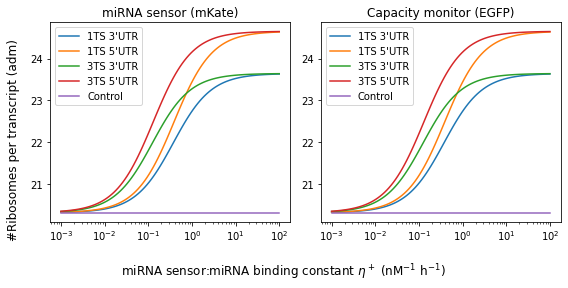

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 4])
for z in range(len(time_series_labels)):
    ax[0].plot(df[z][0].eta_plus, df[z][0].ribo_dens_t, label=time_series_labels[z])
    ax[1].plot(df[z][0].eta_plus, df[z][0].ribo_dens_c, label=time_series_labels[z])
ax[0].set_title('miRNA sensor (mKate)')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].set_title('Capacity monitor (EGFP)')
ax[1].set_xscale('log')
ax[1].legend()
fig.supxlabel(r'miRNA sensor:miRNA binding constant $\eta^+ \ \mathrm{(nM^{-1} \ h^{-1})}$')
fig.supylabel('#Ribosomes per transcript (adm)')
fig.tight_layout()

plt.savefig(os.path.join(imgs_path, 'Fig3b.pdf'), format='pdf')    

## Supplementary Fig. S7

In [8]:
kappas_plus = np.logspace(-2.0, 3.0, num=6)

df = run_sims(scenarios, parameters, kappas_plus, etas_plus)

Generate the figure.

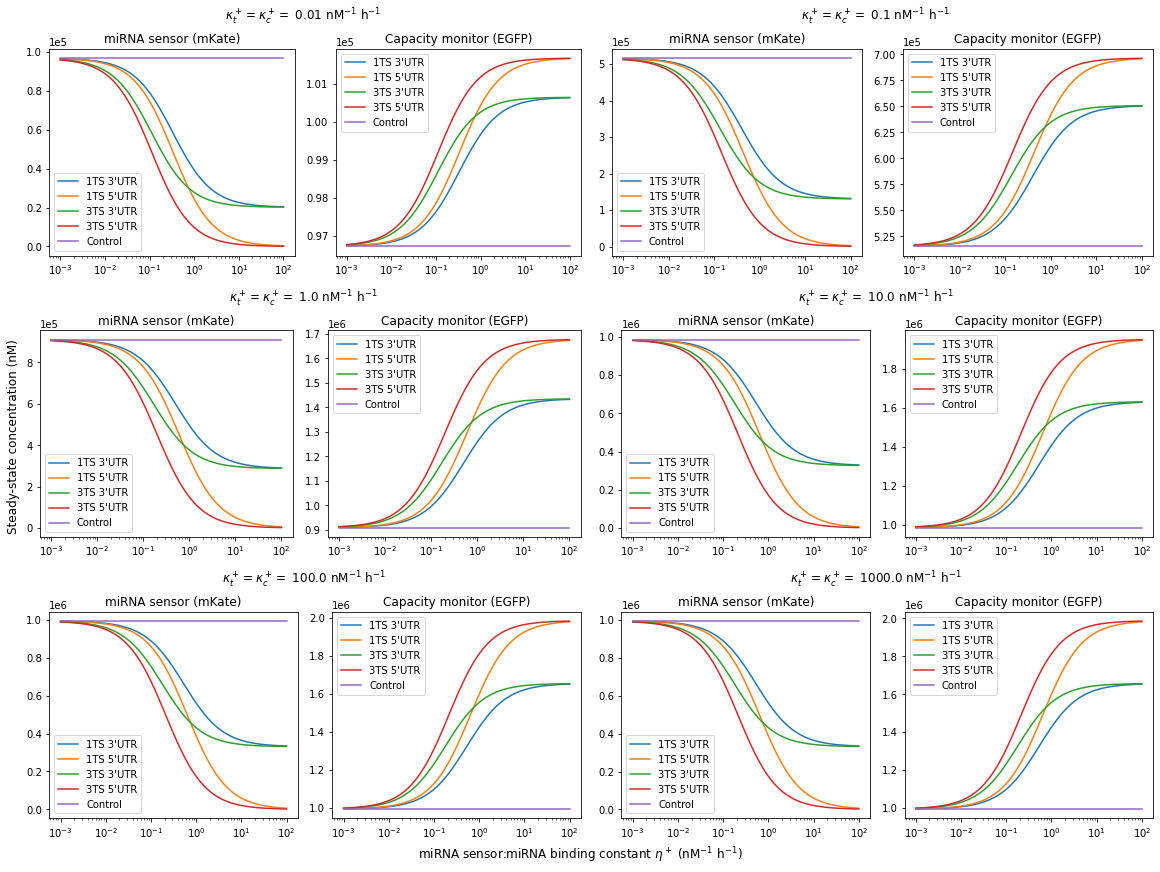

In [9]:
fig = plt.figure(constrained_layout=True, figsize=[16, 12])
subfigs = fig.subfigures(nrows=3, ncols=2)
for i in range(6):
    ax = subfigs[i // 2, i % 2].subplots(nrows=1, ncols=2)
    for z in range(len(time_series_labels)):
        ax[0].plot(df[z][i].eta_plus, df[z][i].pt, label=time_series_labels[z])
        ax[1].plot(df[z][i].eta_plus, df[z][i].pc, label=time_series_labels[z])
        ax[0].set_title('miRNA sensor (mKate)')
        ax[0].set_xscale('log')
        ax[0].legend()
        ax[0].ticklabel_format(axis='y', scilimits=[0, 0])
        ax[1].set_title('Capacity monitor (EGFP)')
        ax[1].set_xscale('log')
        ax[1].legend()
        ax[1].ticklabel_format(axis='y', scilimits=[0, 0])
    subfigs[i // 2, i % 2].suptitle(r'$\kappa_t^+ = \kappa_c^+ = $ {}'.format(df[0][i].kappa_t_plus[0]) + ' $\mathrm{nM^{-1} \ h^{-1}}$')
fig.supxlabel(r'miRNA sensor:miRNA binding constant $\eta^+ \ \mathrm{(nM^{-1} \ h^{-1})}$')
fig.supylabel('Steady-state concentration (nM)')

plt.savefig(os.path.join(imgs_path, 'FigS7.pdf'), format='pdf')